# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

## Adapted From
https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb

# Imports

In [2]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import random

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

sys.path.append("..")
from object_detection.utils import ops as utils_ops


## Env setup

In [3]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [4]:
import warnings; warnings.simplefilter('ignore')
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. 


*See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.*

In [5]:
# What model to download.
# MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_2018_01_28'
MODEL_NAME = 'ssd_mobilenet_v2_coco_2018_03_29'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('object_detection','data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Download Model

In [6]:
## OPTIONAL IF MODEL IS ALREADY DOWNLOADED
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

KeyboardInterrupt: 

## Load a (frozen) Tensorflow model into memory.

In [8]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [9]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [10]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Image Detection Example

In [11]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'images/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'bike.jpg') ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [12]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [13]:
def number_of_bikes(output_dict, category_index):
    objects = [category_index[output_dict['detection_classes'][x]]["name"] for x in range(output_dict['num_detections'])]
    bikes = [1 for x in objects if x == "bicycle"]
    return len(bikes)

Number of Bikes Detected: 4


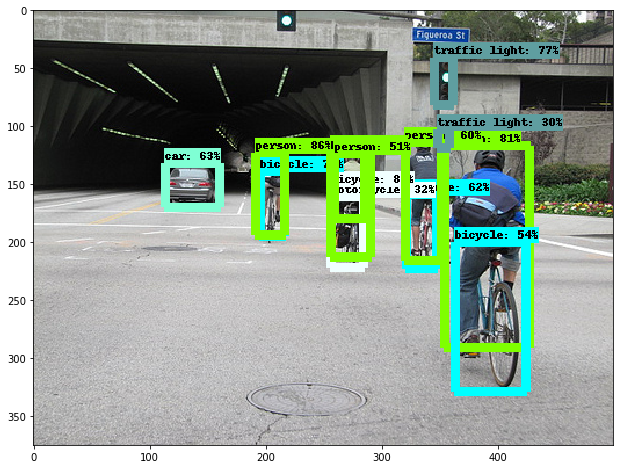

In [14]:
#for image_path in TEST_IMAGE_PATHS:
image_path = "images/bike.jpg"
image = Image.open(image_path)
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection.
output_dict = run_inference_for_single_image(image_np, detection_graph)
# Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
  image_np,
  output_dict['detection_boxes'],
  output_dict['detection_classes'],
  output_dict['detection_scores'],
  category_index,
  instance_masks=output_dict.get('detection_masks'),
  use_normalized_coordinates=True,
  min_score_thresh=0.3,
  line_thickness=8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)

print("Number of Bikes Detected: {0}".format(number_of_bikes(output_dict, category_index)))

# Detecting Bikes in Video Example

### What it does
Takes a frame from a video file at a set interval (determined by the "DETECTIONS_PER_MINUTE" variable) and runs the image detection on that single frame returning how many bikes were detected. This is then uploaded to a dataset for further analysis. This could be parallelized if multiple videos needed to be processed.

In [15]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from datetime import datetime, timedelta

In [16]:
_output_file = 'output/video_out.mp4'
clip = VideoFileClip("videos/bikers2.mp4")

DETECTIONS_PER_MINUTE = 8

In [17]:

def detect_objects(image_np, sess, detection_graph):
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        max_boxes_to_draw=20,
        min_score_thresh=0.3,
        use_normalized_coordinates=True,
        line_thickness=4)
    return image_np

In [18]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image with lines are drawn on lanes)
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            image_process = detect_objects(image, sess, detection_graph)
            return image_process 

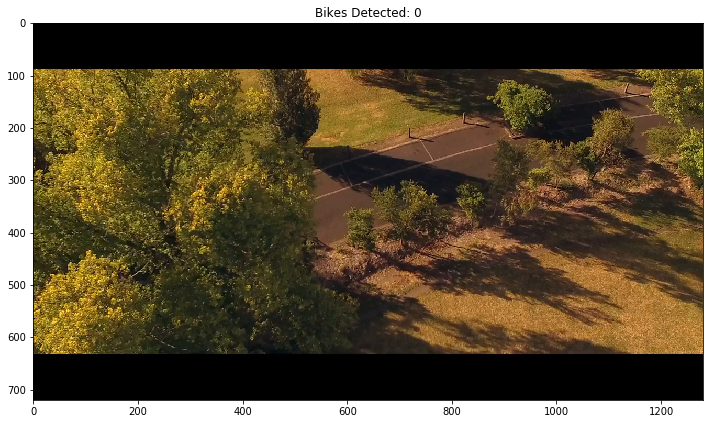

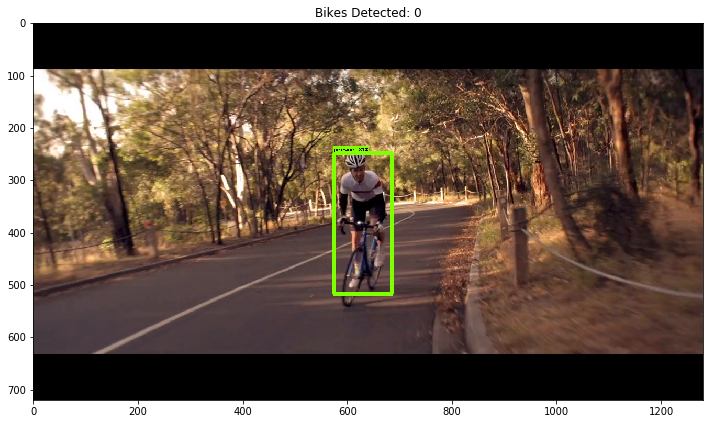

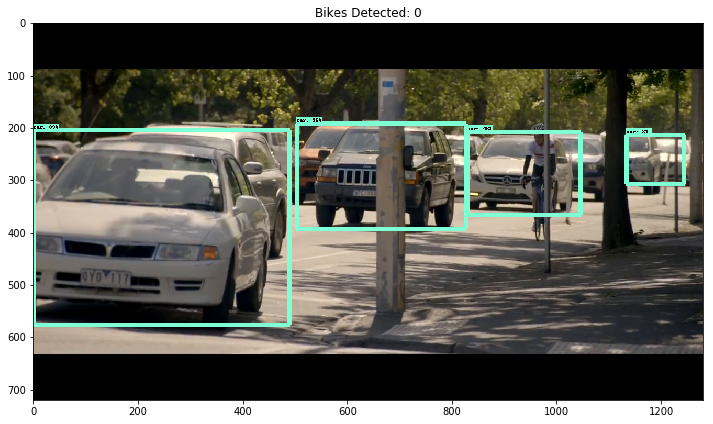

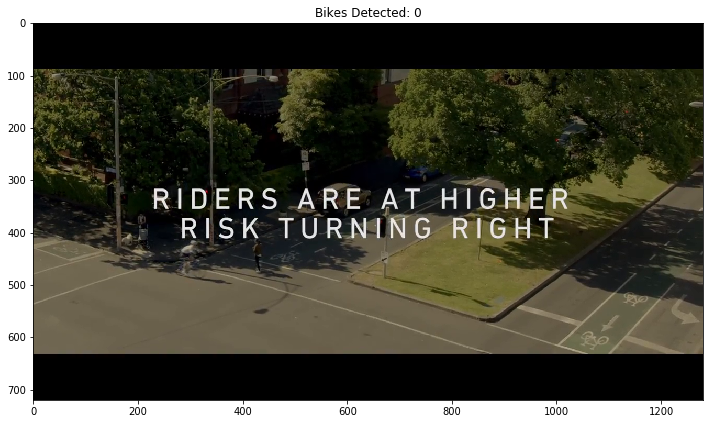

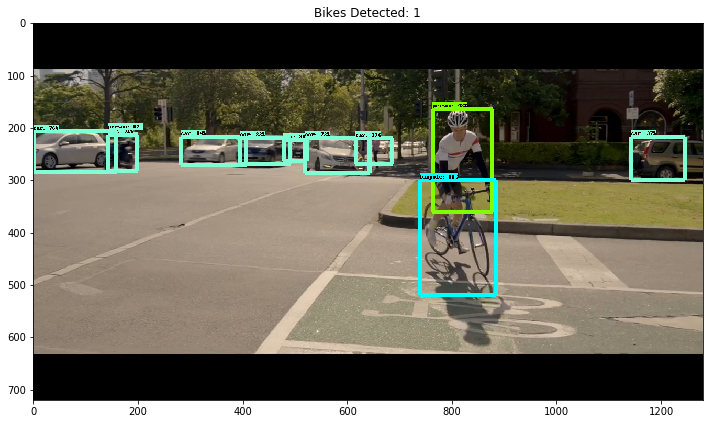

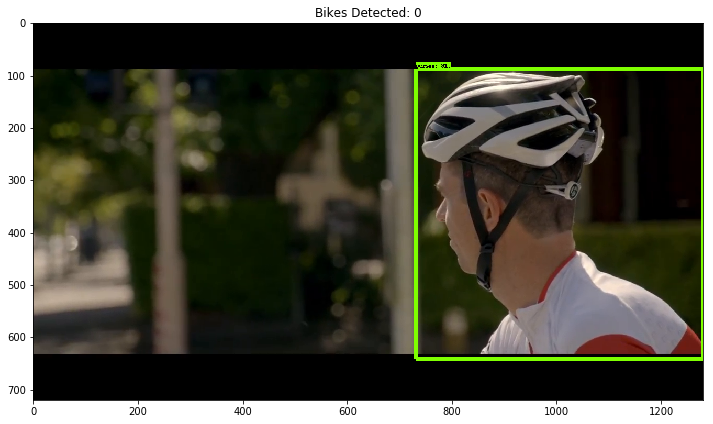

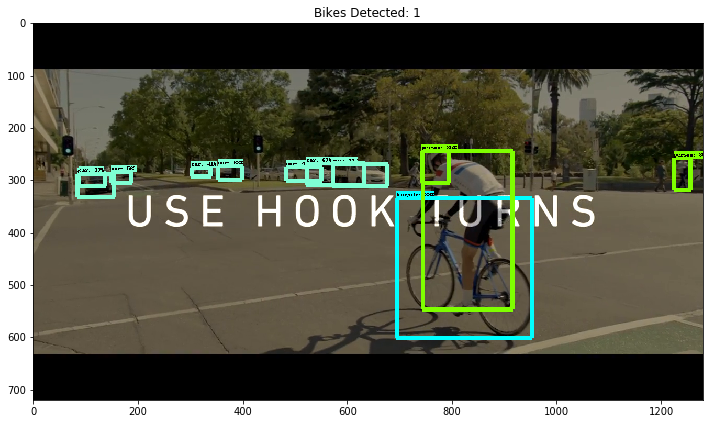

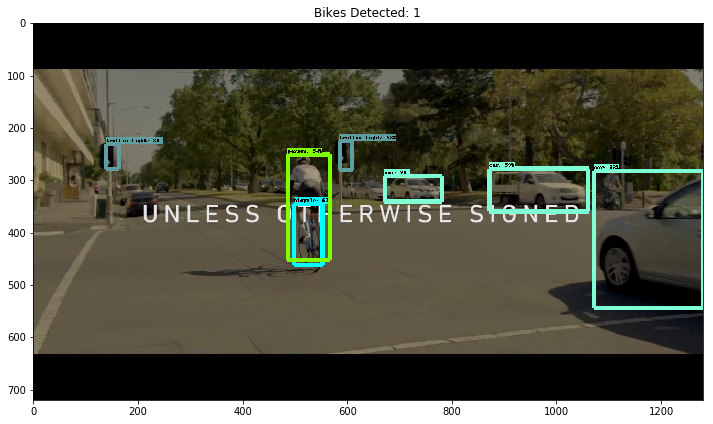

In [19]:
# Split the clip into even sections, run analysis on each frame from that time
# Output image + number of bikes detected
if clip.duration < 60:
    num_detections = DETECTIONS_PER_MINUTE
else:
    num_detections = np.round(clip.duration/60) * DETECTIONS_PER_MINUTE

bike_data = []
clip_start_time = datetime.now()

for x in np.linspace(0, clip.duration, num_detections, endpoint=False):
    image_np = np.array(clip.get_frame(x))
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    num_bikes = number_of_bikes(output_dict, category_index)
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      min_score_thresh=0.3,
      line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.title("Bikes Detected: {0}".format(num_bikes))
    plt.imshow(image_np)
    # In practice, this would have to retrieved from the video source
    bike_data.append({"timestamp": (clip_start_time + timedelta(seconds=x)).strftime("%Y-%m-%dT%H:%M:%S"), "geocoded_location":"POINT (-118.2366543 34.0561379)", "number_of_bikes":num_bikes})
    bike_data.append({"timestamp": (clip_start_time + timedelta(seconds=x)).strftime("%Y-%m-%dT%H:%M:%S"), "geocoded_location":"POINT (-118.2377 34.0566)", "number_of_bikes":num_bikes})
    
    

In [ ]:
# If you wanted to write out the actual video at all times
#boxed_clip = clip.fl_image(process_image)
#boxed_clip.write_videofile(_output_file, audio=False, threads=2, preset='ultrafast')

## Write to Socrata

Using the SODA API to write to the dataset with the new data. Requires Basic Authentication (and write permissions on the domain).

In [20]:
import pandas as pd
df = pd.DataFrame(bike_data)
display(df)

,geocoded_location,number_of_bikes,timestamp
0,POINT (-118.2366543 34.0561379),0,2018-09-12T17:12:59
1,POINT (-118.2377 34.0566),0,2018-09-12T17:12:59
2,POINT (-118.2366543 34.0561379),0,2018-09-12T17:13:02
3,POINT (-118.2377 34.0566),0,2018-09-12T17:13:02
4,POINT (-118.2366543 34.0561379),0,2018-09-12T17:13:04
5,POINT (-118.2377 34.0566),0,2018-09-12T17:13:04
6,POINT (-118.2366543 34.0561379),0,2018-09-12T17:13:07
7,POINT (-118.2377 34.0566),0,2018-09-12T17:13:07
8,POINT (-118.2366543 34.0561379),1,2018-09-12T17:13:10
9,POINT (-118.2377 34.0566),1,2018-09-12T17:13:10


In [21]:
import requests

In [22]:
username = os.getenv("SOCRATA_USERNAME")
password = os.getenv("SOCRATA_PASSWORD")

dataset_url = "{insert API endpoint}"

In [55]:
r = requests.put(dataset_url, json=bike_data, auth=(username,password))
print(r.json())

{u'Rows Deleted': 0, u'Rows Updated': 0, u'Rows Created': 16}


## References

Bike sample video: 

**Cyclists, see a hook turn for bike riders**

Transport Accident Commission Victoria

https://www.youtube.com/watch?v=gRECfaU3j60